# Converting a Keras model to a spiking neural network using NengoDL's Converter

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/keras-to-snn.ipynb)

For users familiar with Keras the NengoDL converter can be a valuable resource. The converter takes in a Keras model and outputs an equivalent Nengo network. The converter also has a `swap_activations` parameter that lets you easily substitute in spiking neurons. For this tutorial, we are going to assume that you've been through the other examples and have basic familiarity with both Nengo and NengoDL. 

The goal of this notebook is to familiarize you with the process of converting a Keras network to a spiking neural network, as well as steps to take to help tune your spiking network to achieve rate neuron performance. We will use these techniques to convert a Keras network for classifing handwritten digits ([MNIST](http://yann.lecun.com/exdb/mnist/)). 

In [1]:
%matplotlib inline

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

First we'll load the training data, the MNIST digits/labels.

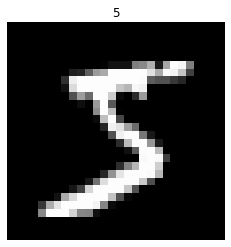

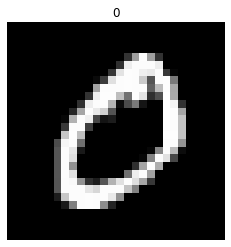

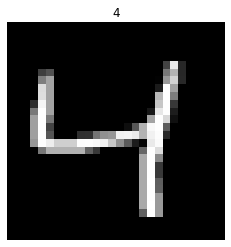

In [2]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data())

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_images[i], (28, 28)),
               cmap="gray")
    plt.axis('off')
    plt.title(str(train_labels[i]));

We need to incorporate time into this data, since Nengo models (and spiking neural networks in general) always run over time. When training the model we'll be using a rate-based approximation, so we can run that for a single timestep. But when testing the model we'll be using the spiking neuron models, so we need to run the model for multiple timesteps in order to collect the spike data over time.

In [3]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of timesteps.
# we're going to create one set that shows each image for 30 time steps
test_images_30 = np.tile(test_images[:, None, :], (1, 30, 1))
test_labels_30 = np.tile(test_labels[:, None, None], (1, 30, 1))
# and one set that shows each image for 100 time steps
test_images_100 = np.tile(test_images[:, None, :], (1, 100, 1))
test_labels_100 = np.tile(test_labels[:, None, None], (1, 100, 1))

## Converting a Keras model to a Nengo network

Next we'll build a simple convolutional network. This architecture is chosen to be a quick and easy solution for this task; other tasks would likely require a different architecture, but the same general principles will apply. The network will be two layers, a convolutional layer and a fully connected layer.

In [60]:
# input
input = tf.keras.Input(shape=(28, 28, 1))

# convolutional layer
conv1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(input)
flatten = tf.keras.layers.Flatten()(conv1)

# fully connected layer
dense1 = tf.keras.layers.Dense(units=10)(flatten)

model = tf.keras.Model(inputs=input, outputs=dense1)

Once the Keras model is created, we can pass it into the Nengo DL Converter. The Converter tool is designed to automate the translation from Keras to Nengo as much as possible. You can see the full list of parameters the Converter accepts in the [Nengo DL API](https://www.nengo.ai/nengo-dl/reference.html?highlight=converter#nengo_dl.Converter).

In [69]:
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)

def augment_network(converter):
    net = converter.net
    # get references to network input and output
    net.input = converter.inputs[input]
    net.output = converter.outputs[dense1]
    
    # add a probe to the convolutional layer to record activity
    nengo_conv1 = converter.layers[conv1]
    with net:
        net.probe = nengo.Probe(nengo_conv1)
        
    return net

net = augment_network(converter)

Now we are ready to train the network. It's important to note that we are using standard rate mode ReLU neurons. The loss function will be the standard categorical cross entropy loss function, optimized with RMSprop.

In order to keep this example relatively quick we are going to download some pretrained weights.  However, if you'd like to run the training yourself set `do_training=True` below.

In [64]:
do_training = False
if do_training:    
    with nengo_dl.Simulator(net, seed=0) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.RMSprop(0.001),
            loss={nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True)}
        )
        sim.fit(train_images, {nengo_output: train_labels}, epochs=10)

        # save the parameters to file
        sim.save_params("./mnist_params_keras_to_snn")
else:
    # download pretrained weights
    urlretrieve(???)

SyntaxError: invalid syntax (<ipython-input-64-83b42dccc725>, line 15)

Now that we have our trained up network weights, we can begin the conversion to spiking neurons. To help us in this process we're going to first define a few helper functions. These first few are for plotting:

In [38]:
def plot_predictions(data, test_labels, n_test):
    """ Plot the network's digit prediction (max of outputs) against answers """
    plt.figure()
    plt.title('Network predictions')
    # plot the answers as large red x's
    plt.plot(test_labels[:n_test].squeeze(), 'rx', mew=15)
    # plot the network prediction on the last time step of each batch as blue o's
    plt.plot(np.argmax(data[:, -1], axis=1), 'o', mew=2)
    
    plt.grid()
    plt.ylabel('Digit')
    plt.xlabel('Batch')
    plt.ylim([-.5, 9.5])  # possible network outputs are 0-9
    plt.xticks(range(n_test), range(n_test))
    plt.yticks(range(10), range(10))

In [81]:
def plot_neural_activity(data, n_test, n_neurons=5000, activation=None, scale=1):
    """ Plot the activity of the convolutional layer """
    if activation == nengo.SpikingRectifiedLinear():
        scale *= 0.001
        plt.ylabel('Number of spikes')
    else:
        plt.ylabel('Firing rates (Hz)')
    data *= scale
        
    plt.figure()
    plt.title('Neuron activity (max = %.3f)' % np.max(data.flatten()))
    # reshape data for 0:n_timesteps = batch 0, n_timesteps:2*n_timesteps = batch 1, etc
    plt.plot(data[:n_test, :, :n_neurons].reshape(-1, n_neurons))
    
    plt.xlabel('Time (s)')

In [40]:
def plot_network_activity(data, n_test, n_outputs):
    """ Plot the output activity of the network over time """
    plt.figure()
    # reshape data for 0:n_timesteps = batch 0, n_timesteps:2*n_timesteps = batch 1, etc
    data = data[:n_test].reshape(-1, 10)

    for ii in range(n_outputs):
        plt.subplot(n_outputs, 1, ii+1)
        plt.plot(data[:, ii])
        plt.ylabel('%i' % ii)

    # ??? how to use suptitle with plt.tight_layout ???
    plt.suptitle('Network predictions of each digit')
    plt.xlabel('Time (s)')
    plt.ylabel('Decoded')
    # plt.tight_layout()

And this helper function will build the network for us, load weights from a specified file, and make it easy to play around with some other features of the network.

In [73]:
def run_network(activation, params_file, test_images, test_labels,
                scale_firing_rates=1, synapse=None, n_test=5):
    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
    )
    net = augment_network(converter)
       
    # if specified, apply low-pass filter with synapse time constant to all connection
    if synapse is not None:
        for conn in net.all_connections:
            conn.synapse = synapse
            
    # build network, load in trained weights, run inference on n_test images
    with nengo_dl.Simulator(net, minibatch_size=1, seed=0) as sim:
        sim.load_params(params_file)
        data = sim.predict({net.input: test_images[:n_test]})
        
    # plot the results
    plot_predictions(data[net.output], test_labels, n_test=n_test)
    plot_neural_activity(data[net.probe], n_test=n_test, activation=activation, scale=scale_firing_rates)
    plot_network_activity(data[net.output], n_test=n_test, n_outputs=4)

Now to run our trained network, all we have to do is:

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


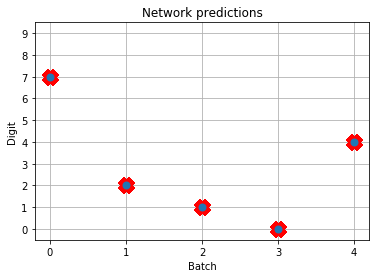

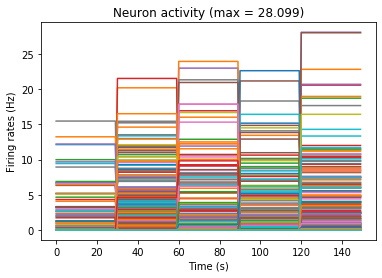

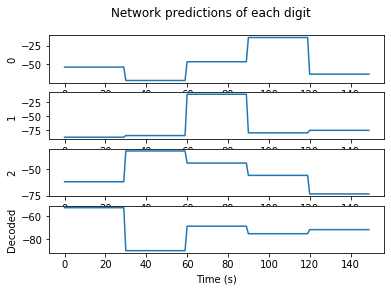

In [71]:
# run the network in rate mode
run_network(
    activation=nengo.RectifiedLinear(),
    params_file='mnist_params',
    test_images=test_images_30,
    test_labels=test_labels_30,
)

## Converting to a spiking neural network

Now that we have the rate neuron version working in Nengo, we can start converting the network into spikes. Using the Nengo DL converter, this amounts to specifying `nengo.SpikingRectifiedLinear()` as the activation function we'd like to swap in in the `swap_activations` parameter when we call the `Converter`.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


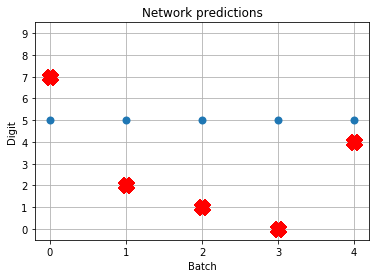

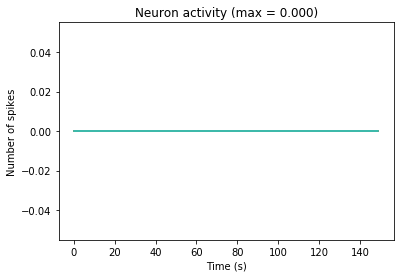

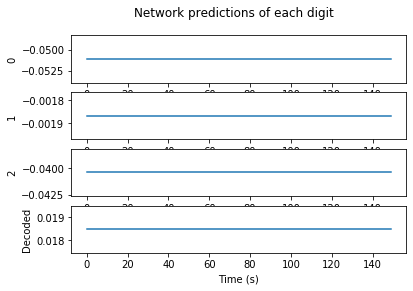

In [74]:
# run the network with spiking neurons
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file='mnist_params',
    test_images=test_images_30,
    test_labels=test_labels_30,
)

In this naive conversion, without any tuning, there is no activity in the network! Referring back to the Neural Activity plot from our rate mode network we can gain a bit of insight into why this occurs. Note that the firing rates are all around or below 30 Hz. 30 Hz = 1 spike every ~33 milliseconds. We're simulating 30 time steps = 30 milliseconds for each image. If we present each image for longer we should start seeing some activity.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


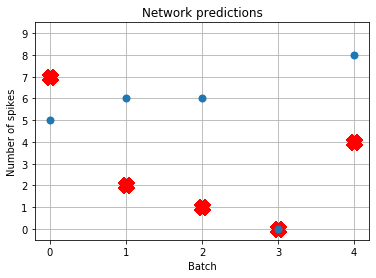

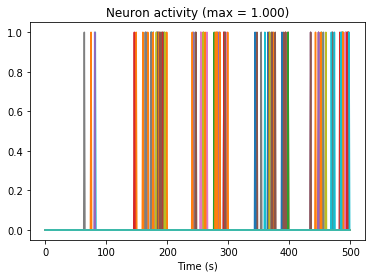

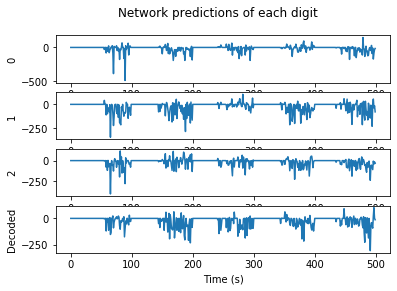

In [82]:
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file='mnist_params',
    test_images=test_images_100,
    test_labels=test_labels_100,
)

This shows that while initially there's no network activity, eventually we do start gettign some spikes. You'll note, however, that the Network Predictions are way off. In part, this is because the network output is very noisy. You can see in the Network predictions of each digit plot that the output fluctuates between 0 and 250 very rapidly. This is because spikes are discrete output, that exist for only a single time step and then disappear. 

One way that we can compensate for this rapid fluctuation in the network output is to apply a filter to the spikes. Synapses can be used to accomplish this. The default `synapse` used in Nengo is a low-pass filter, and when you specify a value for the `synapse` parameter, that value is used as the low-pass filter time constant. When we pass a `synapse` value in to the `run_network` function, it will create a low-pass filter with that time constant on every connection in the network.

Below we show results from the network running with three different low-pass filters.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


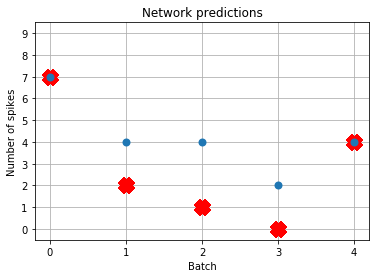

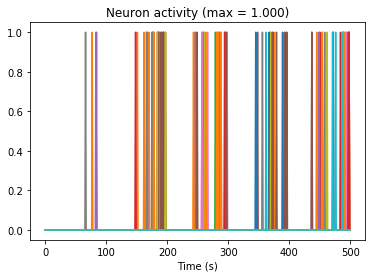

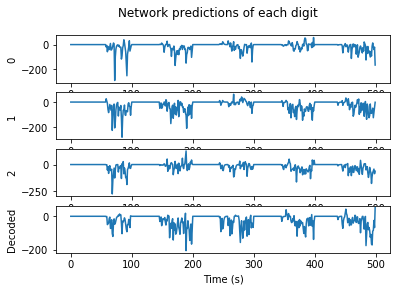

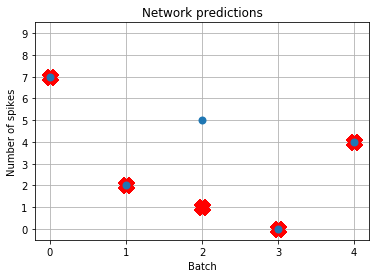

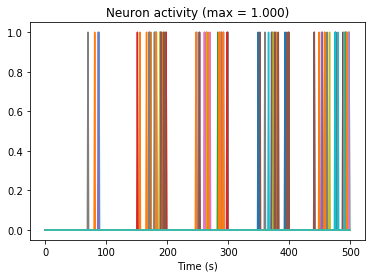

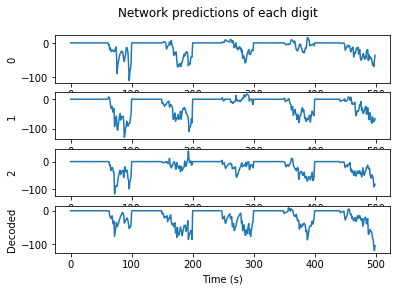

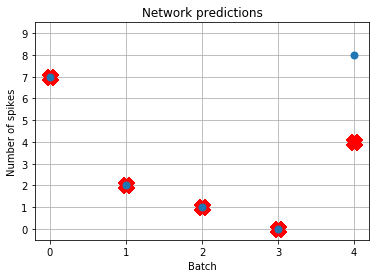

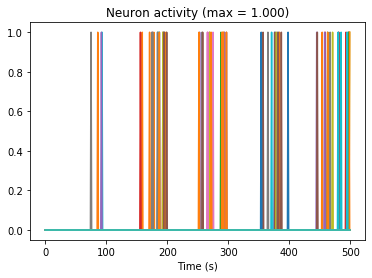

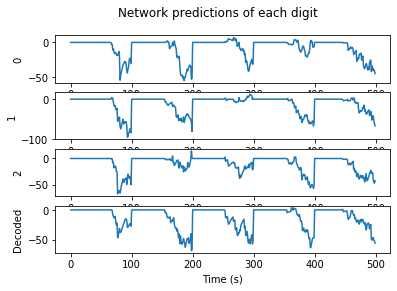

In [83]:
# run the network with spiking neurons showing each input for 100ms and using synapses
for synapse in [0.001, 0.005, 0.01]:
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        params_file='mnist_params',
        test_images=test_images_100,
        test_labels=test_labels_100,
        synapse=synapse,
    )

In the above test cases, we're able to achieve 4/5 by smoothing the network output with synapses. However, we're still presenting the image for 100 time steps, where rate networks make a prediction in 1 time step. We'll move back to presenting the image for only 30 time steps for now.

Another way that we can improve network performance is by increasing the firing rate of the neurons, which brings their behaviour closer to that of rate neurons. 

For `RectifiedLinear` neurons, we can increase firing rates without changing the network behaviour by multiplying the input signal by a scaling term and dividing the neuron output by the same scaling term. To apply this using the Nengo DL `Converter`, you can set the `scale_firing_rates` parameter.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


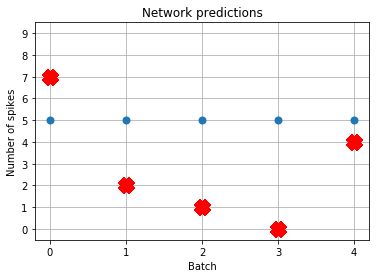

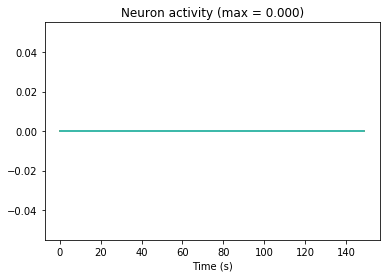

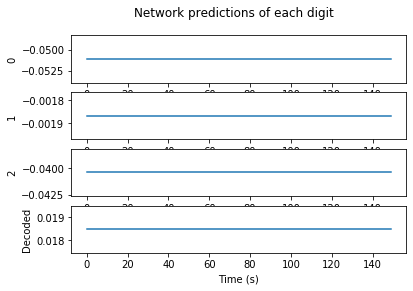

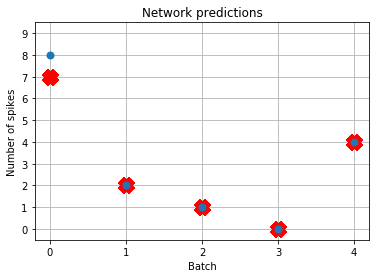

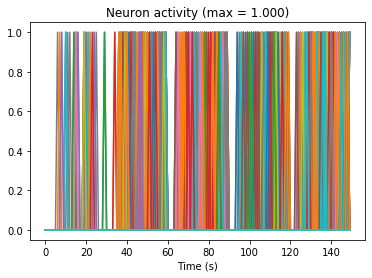

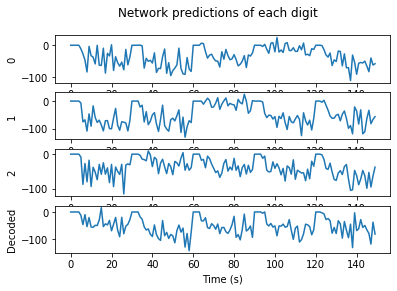

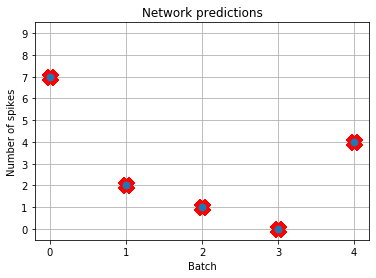

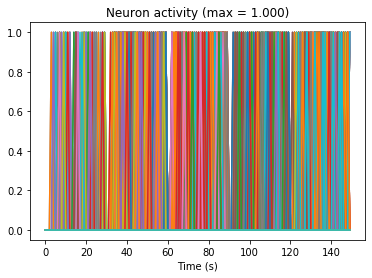

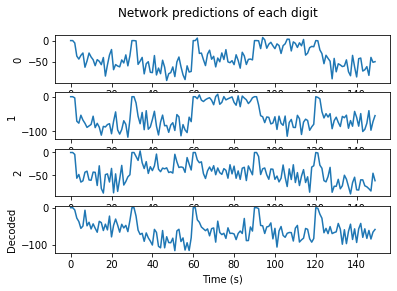

In [84]:
for scale in [1, 10, 20]:
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        params_file='mnist_params',
        test_images=test_images_30,
        test_labels=test_labels_30,
        scale_firing_rates=scale,
    )

You can see that as the frequency of spiking increases in the network, the performance in accurately predicting which digit has been presented also increases.

This method is most effective for `RectifiedLinear` neurons. For other activation functions with stronger nonlinearities, we can increase their firing rates by adding a term to the cost function that penalizes firing rates outside of our desired range.

In [78]:
def put_in_range(x, y, weight=100.0, min=200, max=300):
    index_greater = (y > max)
    index_lesser = (y < min)
    error = tf.reduce_sum(y[index_greater] - max) + tf.reduce_sum(min - y[index_lesser])
    return weight * error

do_training = False
if do_training:
    net, nengo_input, nengo_output, probe_conv1 = convert_network()
    
    with nengo_dl.Simulator(net, seed=0) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.RMSprop(0.001),
            loss={nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  probe_conv1: put_in_range},
        )

        sim.fit(
            train_images, 
            {nengo_output: train_labels, 
             probe_conv1: np.zeros(train_labels.shape)},
            epochs=10)

        # save the parameters to file
        sim.save_params("./mnist_params_keras_to_snn_fr_loss")
else:
    # download pretrained weights
    urlretrieve(???)

SyntaxError: invalid syntax (<ipython-input-78-7969f886b03a>, line 29)

Now we can examine the firing rates in the rate neuron network.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


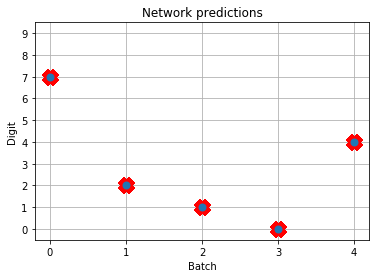

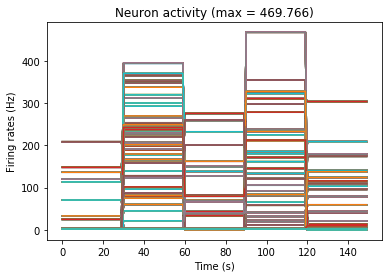

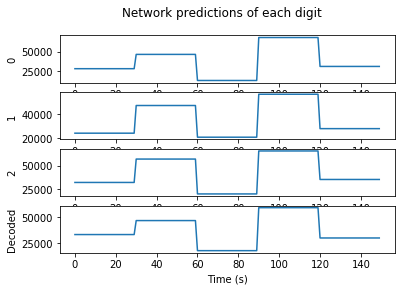

In [79]:
run_network(
    activation=nengo.RectifiedLinear(),
    params_file='mnist_params_with_fr_loss',
    test_images=test_images_30,
    test_labels=test_labels_30
)

In the Neuron Activity plot we can see that the are about 10x as large as before. Now when we convert to spiking neurons we expect to see better performance.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               


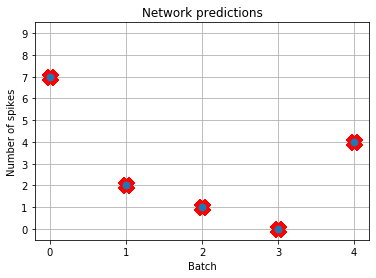

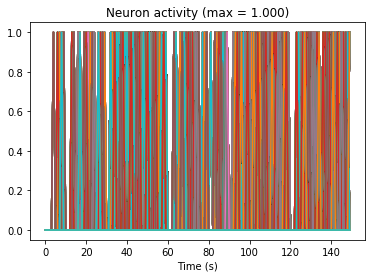

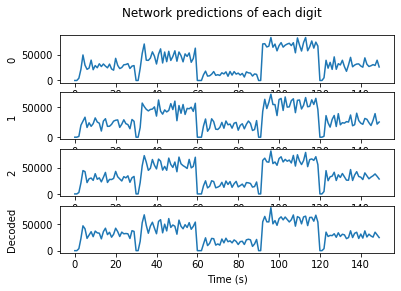

In [85]:
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file='mnist_params_with_fr_loss',
    test_images=test_images_30,
    test_labels=test_labels_30
)

The network correctly predicts 5/5 test images. Of course this is an incredibly small test set and you should run proper statistics over a standard size test set, but hopefully you now have a sense of some of the knobs that can be tuned and how to go about debugging improper behaviour.